In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/hieutt/electricity_theft_detection/../', '/home/hieutt/electricity_theft_detection/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [5]:
import os
import numpy as np
import pandas as pd

# ==========================================
# 1. HÀM LOAD & XỬ LÝ DỮ LIỆU (ĐÃ NÂNG CẤP)
# ==========================================
def load_halfhour_txt(path):
    # Đọc file space-separated
    try:
        df = pd.read_csv(path, sep=r"\s+", header=None, names=["id", "slot", "kwh"])
        # Chuyển kwh sang số, nếu lỗi thì biến thành NaN
        df['kwh'] = pd.to_numeric(df['kwh'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error reading txt: {e}")
        return None

def process_single_user_data(df_user):
    """
    Xử lý dữ liệu của 1 user:
    1. Sắp xếp theo slot.
    2. Điền dữ liệu thiếu (Interpolate).
    3. Gom nhóm 30p -> 1h.
    4. Cắt thành các tuần 168h.
    """
    # 1. Sắp xếp
    df_user = df_user.sort_values('slot').drop_duplicates(subset=['slot'])
    
    if len(df_user) < 336: # Cần ít nhất 1 tuần (168h * 2 slot/h = 336 slots)
        return []

    # 2. Xử lý thiếu dữ liệu (Missing Data)
    # Tạo index đầy đủ từ slot min đến slot max
    min_slot = df_user['slot'].min()
    max_slot = df_user['slot'].max()
    full_range = np.arange(min_slot, max_slot + 1)
    
    # Reindex để lòi ra các slot bị thiếu (sẽ là NaN)
    df_user = df_user.set_index('slot').reindex(full_range)
    
    # Nội suy tuyến tính để lấp đầy NaN (Linear Interpolation)
    # limit=4 nghĩa là nếu mất điện quá 2 tiếng (4 slot) liên tục thì không bịa số nữa
    df_user['kwh'] = df_user['kwh'].interpolate(method='linear', limit=4)
    
    # Nếu vẫn còn NaN (do mất quá lâu hoặc ở đầu/cuối), điền bằng 0 hoặc bỏ qua
    # Ở đây ta fill 0 cho đơn giản để giữ mạch thời gian
    df_user['kwh'] = df_user['kwh'].fillna(0.0)
    
    # Reset index để có cột slot (giờ là index mới)
    df_user = df_user.reset_index().rename(columns={'index': 'slot'})
    
    # 3. Chuyển sang Hourly (Gom 2 slot thành 1 giờ)
    # Tính hour_idx tương đối từ mốc bắt đầu
    df_user['hour_idx'] = ((df_user['slot'] - min_slot) // 2).astype(int)
    
    # Group by hour và lấy trung bình
    df_hourly = df_user.groupby('hour_idx')['kwh'].mean()
    
    # 4. Cắt thành các cửa sổ 168 giờ (Sliding Window)
    # Chuyển thành numpy array
    values = df_hourly.values 
    X_list = []
    window_size = 168
    stride = 1  
    
    num_samples = (len(values) - window_size) // stride + 1
    
    if num_samples <= 0:
        return []
        
    for i in range(0, len(values) - window_size + 1, stride):
        sample = values[i : i + window_size]
        # Kiểm tra nếu mẫu quá nhiều số 0
        if (sample == 0).sum() > 24: 
            continue
        X_list.append(sample)
        
    return X_list

def build_benign_from_folder(folder):
    print(f"Scanning folder: {folder}...")
    all_benign = []
    if not os.path.exists(folder):
        print(f"Error: Folder {folder} not found!")
        return np.empty((0, 168), dtype=float)
        
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.txt')])
    print(f"Found {len(files)} files.")
    
    total_samples = 0
    
    for i, fname in enumerate(files):
        path = os.path.join(folder, fname)
        df = load_halfhour_txt(path)
        
        if df is None or df.empty:
            continue
            
        # Một file có thể chứa nhiều ID, xử lý từng ID
        user_groups = df.groupby('id')
        
        for user_id, group in user_groups:
            # Xử lý logic nội suy và cắt cửa sổ
            samples = process_single_user_data(group)
            
            if len(samples) > 0:
                all_benign.append(samples)
                total_samples += len(samples)
                
        if (i+1) % 1 == 0: # In log mỗi file để check
            print(f"  Processed {fname}: Got {total_samples} samples so far...")
            
    if not all_benign:
        return np.empty((0, 168), dtype=float)
        
    # Gộp tất cả list lại (Flatten)
    # all_benign đang là list of lists [[vec, vec], [vec, vec]...]
    flat_list = [item for sublist in all_benign for item in sublist]
    
    return np.vstack(flat_list)

In [9]:
# ==========================================
# 2. ĐỊNH NGHĨA ATTACK (168H)
# ==========================================
_rng_global = np.random.default_rng(42)

def atk_h1_scale_down(x, rng=None): 
    rng = _rng_global if rng is None else rng
    beta = rng.uniform(0.1, 0.4) 
    return beta * x

def atk_h2_rand_scale_per_hour(x, rng=None):
    rng = _rng_global if rng is None else rng
    gamma = rng.uniform(0.05, 0.5, size=x.shape[0]) 
    return gamma * x

def atk_h3_mean_flat(x):
    mu = x.mean()
    return np.full(x.shape[0], mu, dtype=float)

def atk_h4_mean_scaled(x, rng=None):
    rng = _rng_global if rng is None else rng
    mu = x.mean()
    gamma = rng.uniform(0.1, 0.4, size=x.shape[0]) 
    return gamma * mu

def atk_h5_zero_interval(x, rng=None):
    rng = _rng_global if rng is None else rng
    x2 = x.copy()
    N = x.shape[0]
    t_start = rng.integers(0, N // 2) 
    x2[t_start:] = 0.0
    return x2

def atk_h6_reverse_day(x):
    return x[::-1].copy()

ATK_FUNCS = {
    1: atk_h1_scale_down, 2: atk_h2_rand_scale_per_hour,
    3: atk_h3_mean_flat, 4: atk_h4_mean_scaled,
    5: atk_h5_zero_interval, 6: atk_h6_reverse_day,
}

In [10]:
# ==========================================
# 3. GENERATE MAIN
# ==========================================
def gen_attacks_quota(X_base, atk_id, n_target, seed):
    fn = ATK_FUNCS[atk_id]
    rng_local = np.random.default_rng(seed)
    outs = []
    NEEDS_RNG = [1, 2, 4, 5] 
    
    # Lấy lặp lại X_base nếu cần để đủ số lượng
    while sum(len(o) for o in outs) < n_target:
        # Nếu X_base ít hơn n_target, ta cần random seed khác nhau cho mỗi lần lặp
        seeds = rng_local.integers(1<<30, size=len(X_base))
        batch_atk = []
        for i, x in enumerate(X_base):
            s_i = np.random.default_rng(seeds[i])
            if atk_id in NEEDS_RNG:
                batch_atk.append(fn(x, rng=s_i))
            else:
                batch_atk.append(fn(x))
        outs.append(np.vstack(batch_atk).astype(np.float32))
        
        # Nếu X_base quá lớn, chỉ chạy 1 vòng là đủ
        if len(outs[-1]) >= n_target: break
        
    A_all = np.vstack(outs)
    # Trộn và cắt đúng số lượng
    if len(A_all) > n_target:
        # Shuffle nhẹ để không bị lấy trùng lặp các mẫu đầu
        perm = rng_local.permutation(len(A_all))
        A_all = A_all[perm[:n_target]]
        
    return A_all

# ---- RUN ----
if __name__ == "__main__":
    folder = '../data/CER_ETD' # Đảm bảo đường dẫn đúng
    
    # 1. Load Data (Robust)
    print("--- 1. Loading Data ---")
    X_benign_raw = build_benign_from_folder(folder)
    print(f'\nFinal Benign Pool Shape: {X_benign_raw.shape}')

    if len(X_benign_raw) < 100:
        print("CRITICAL WARNING: Too few benign samples to train Deep Learning.")
        print("Try reducing 'window_size' or 'stride' in process_single_user_data function.")
        if len(X_benign_raw) == 0: exit()

    # 2. Global Normalization
    print("\n--- 2. Global Normalization ---")
    global_max = X_benign_raw.max()
    global_min = X_benign_raw.min()
    print(f"Max: {global_max:.4f}, Min: {global_min:.4f}")

    def normalize_global(X, g_min, g_max):
        return (X - g_min) / (g_max - g_min + 1e-9)

    X_benign = normalize_global(X_benign_raw, global_min, global_max)

    # 3. Split Index
    SEED_SPLIT = 123
    rng = np.random.default_rng(SEED_SPLIT)
    N = len(X_benign)
    idx = np.arange(N)
    # rng.shuffle(idx)

    cut = int(round(N * 0.7))
    idx_train_pool = idx[:cut]
    idx_test_pool = idx[cut:]

    # 4. Generate Train (Balanced)
    SAMPLES_PER_CLASS_TRAIN = 3000
    
    # Nếu pool train ít hơn 3000 mẫu, ta phải cho phép lấy lặp lại (bootstrap)
    # Logic: rng.choice(..., replace=True) nếu thiếu
    replace_flag = len(idx_train_pool) < SAMPLES_PER_CLASS_TRAIN
    
    print("\n--- 3. Generating Train ---")
    X_train_benign = X_benign[rng.choice(idx_train_pool, size=SAMPLES_PER_CLASS_TRAIN, replace=replace_flag)]
    train_X_list = [X_train_benign]
    train_y_list = [np.zeros(len(X_train_benign), dtype=np.int64)]
    
    X_train_source = X_benign[idx_train_pool]
    for aid in range(1, 7):
        A = gen_attacks_quota(X_train_source, aid, SAMPLES_PER_CLASS_TRAIN, seed=1000+aid)
        train_X_list.append(A)
        train_y_list.append(np.full(len(A), aid, dtype=np.int64)) # Label 1..6 cho Multi (sau này map về binary sau)

    X_tr = np.vstack(train_X_list).astype(np.float32)
    y_tr = np.concatenate(train_y_list).astype(np.int64)

    # 5. Generate Val (Randomized)
    print("\n--- 4. Generating Val ---")
    val_X_list = []
    val_y_list = []
    X_val_source = X_benign[idx_test_pool]
    
    # Benign
    N_VAL_BENIGN = 6000
    replace_flag_val = len(idx_test_pool) < N_VAL_BENIGN
    X_val_benign = X_benign[rng.choice(idx_test_pool, size=N_VAL_BENIGN, replace=replace_flag_val)]
    
    val_X_list.append(X_val_benign)
    val_y_list.append(np.zeros(len(X_val_benign), dtype=np.int64))
    
    # Attack
    rng_val = np.random.default_rng(999)
    for aid in range(1, 7):
        n_target = rng_val.integers(1000, 2001)
        A = gen_attacks_quota(X_val_source, aid, n_target, seed=2000+aid)
        val_X_list.append(A)
        val_y_list.append(np.full(len(A), aid, dtype=np.int64))

    X_te = np.vstack(val_X_list).astype(np.float32)
    y_te = np.concatenate(val_y_list).astype(np.int64)

    # 6. Save
    def shuffle_data(X, y, seed):
        r = np.random.default_rng(seed)
        i = r.permutation(len(X))
        return X[i], y[i]

    X_tr, y_tr = shuffle_data(X_tr, y_tr, seed=777)
    X_te, y_te = shuffle_data(X_te, y_te, seed=888)

    out_dir = './prepared_etd_weekly_168'
    os.makedirs(out_dir, exist_ok=True)
    np.savez(os.path.join(out_dir, 'train.npz'), data=X_tr, label=y_tr) 
    np.savez(os.path.join(out_dir, 'val.npz'),  data=X_te, label=y_te)
    print(f"\nSaved to {out_dir}")
    print(f"Train Shape: {X_tr.shape}")
    print(f"Val Shape:   {X_te.shape}")

--- 1. Loading Data ---
Scanning folder: ../data/CER_ETD...
Found 6 files.
  Processed File1.txt: Got 259 samples so far...
  Processed File2.txt: Got 259 samples so far...
  Processed File3.txt: Got 259 samples so far...
  Processed File4.txt: Got 259 samples so far...
  Processed File5.txt: Got 518 samples so far...
  Processed File6.txt: Got 518 samples so far...

Final Benign Pool Shape: (518, 168)

--- 2. Global Normalization ---
Max: 4.6865, Min: 0.0000

--- 3. Generating Train ---

--- 4. Generating Val ---

Saved to ./prepared_etd_weekly_168
Train Shape: (21000, 168)
Val Shape:   (14834, 168)


Visualizing Weekly Data Patterns...


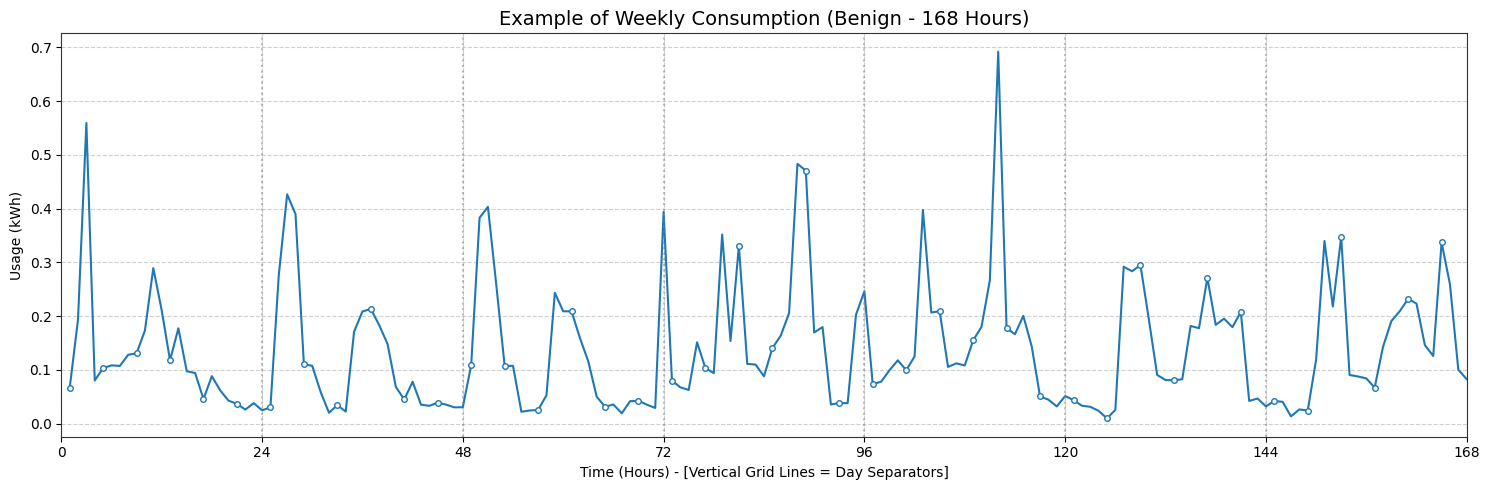

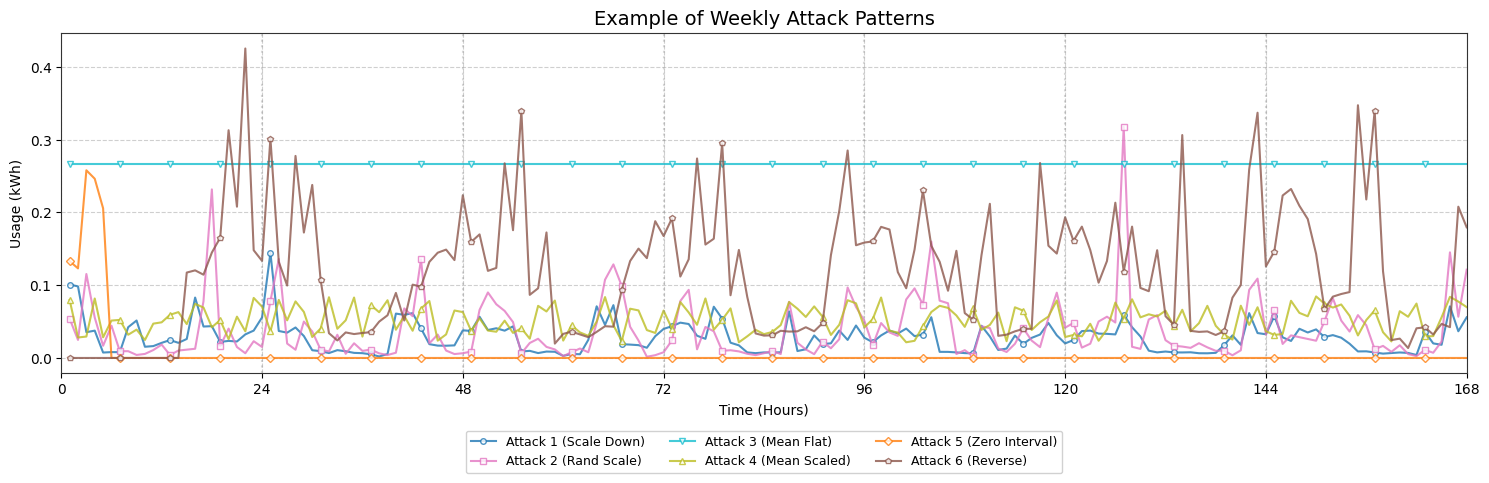

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Cấu hình style (Giữ nguyên phong cách sạch, marker rỗng)
plt.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.edgecolor": "#333333",
    "font.size": 10,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "figure.figsize": (15, 5),  # Tăng kích thước chút xíu để chứa 168 điểm
    "lines.linewidth": 1.5,     # Giảm độ dày nét một chút cho dữ liệu dày đặc
    "lines.markersize": 4,      # Giảm kích thước marker vì nhiều điểm hơn
    "lines.markeredgewidth": 1.0,
})

def visualize_weekly_patterns(X, y):
    """
    Vẽ 2 hình cho dữ liệu TUẦN (168 giờ):
    1. Một mẫu Benign (Class 0)
    2. Tổng hợp 6 mẫu Attack (Class 1-6)
    """
    # Trục X từ 1 đến 168 (7 ngày * 24 giờ)
    hours = np.arange(1, 169) 
    rng_viz = np.random.default_rng()
    
    # Thiết lập vạch chia trục X theo ngày (0, 24, 48...)
    xticks_loc = np.arange(0, 169, 24)
    # Label cho trục X (Day 1, Day 2...)
    xtick_labels = [f'{i}' for i in range(len(xticks_loc))] 
    # Hoặc chỉ để số giờ: 0, 24, 48...
    
    # --- FIGURE 1: BENIGN ONLY ---
    plt.figure()
    
    idx_benign = np.where(y == 0)[0]
    if len(idx_benign) > 0:
        idx = rng_viz.choice(idx_benign)
        sample = X[idx]
        
        plt.plot(hours, sample, 
                 color='#1f77b4',       
                 marker='o',            
                 markerfacecolor='white',
                 markevery=4, # Chỉ vẽ marker mỗi 4 điểm cho đỡ rối (vì 168 điểm rất dày)
                 label='Benign (Weekly)')
        
    plt.title("Example of Weekly Consumption (Benign - 168 Hours)", fontsize=14)
    plt.xlabel("Time (Hours) - [Vertical Grid Lines = Day Separators]")
    plt.ylabel("Usage (kWh)")
    plt.xlim(0, 168)
    plt.xticks(xticks_loc)
    
    # Vẽ thêm đường kẻ dọc phân cách các ngày để dễ nhìn
    for day_sep in xticks_loc[1:-1]:
        plt.axvline(x=day_sep, color='gray', linestyle=':', alpha=0.5)
        
    plt.tight_layout()
    plt.show()
    
    # --- FIGURE 2: ALL ATTACKS COMBINED ---
    plt.figure()
    
    styles = {
        1: {'color': '#1f77b4', 'marker': 'o', 'label': 'Attack 1 (Scale Down)'},
        2: {'color': '#e377c2', 'marker': 's', 'label': 'Attack 2 (Rand Scale)'},
        3: {'color': '#17becf', 'marker': 'v', 'label': 'Attack 3 (Mean Flat)'},
        4: {'color': '#bcbd22', 'marker': '^', 'label': 'Attack 4 (Mean Scaled)'},
        5: {'color': '#ff7f0e', 'marker': 'D', 'label': 'Attack 5 (Zero Interval)'},
        6: {'color': '#8c564b', 'marker': 'p', 'label': 'Attack 6 (Reverse)'}
    }
    
    has_data = False
    for aid in range(1, 7):
        idxs = np.where(y == aid)[0]
        if len(idxs) > 0:
            idx = rng_viz.choice(idxs)
            sample = X[idx]
            s = styles[aid]
            
            plt.plot(hours, sample, 
                     color=s['color'], 
                     marker=s['marker'],
                     markerfacecolor='white',
                     markevery=6, # Marker thưa hơn để nhìn được nhiều đường chồng lên nhau
                     label=s['label'],
                     alpha=0.8)
            has_data = True
            
    if has_data:
        plt.title("Example of Weekly Attack Patterns", fontsize=14)
        plt.xlabel("Time (Hours)")
        plt.ylabel("Usage (kWh)")
        plt.xlim(0, 168)
        plt.xticks(xticks_loc)
        
        # Kẻ vạch phân cách ngày
        for day_sep in xticks_loc[1:-1]:
            plt.axvline(x=day_sep, color='gray', linestyle=':', alpha=0.3)

        plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=9)
        
    plt.tight_layout()
    plt.show()

# --- CHẠY VISUALIZE ---
print("Visualizing Weekly Data Patterns...")
# Truyền dữ liệu tuần (168 features) vào đây
visualize_weekly_patterns(X_tr, y_tr)

In [13]:
# ==========================================
# 3. GENERATE MAIN
# ==========================================
def gen_attacks_quota(X_base, atk_id, n_target, seed):
    fn = ATK_FUNCS[atk_id]
    rng_local = np.random.default_rng(seed)
    outs = []
    NEEDS_RNG = [1, 2, 4, 5] 
    
    while sum(len(o) for o in outs) < n_target:
        seeds = rng_local.integers(1<<30, size=len(X_base))
        batch_atk = []
        for i, x in enumerate(X_base):
            s_i = np.random.default_rng(seeds[i])
            if atk_id in NEEDS_RNG:
                batch_atk.append(fn(x, rng=s_i))
            else:
                batch_atk.append(fn(x))
        outs.append(np.vstack(batch_atk).astype(np.float32))
        if len(outs[-1]) >= n_target: break
        
    A_all = np.vstack(outs)
    if len(A_all) > n_target:
        perm = rng_local.permutation(len(A_all))
        A_all = A_all[perm[:n_target]]
    return A_all

# ---- RUN ----
if __name__ == "__main__":
    folder = '../data/CER_ETD' 
    
    # 1. Load Data
    print("--- 1. Loading Data ---")
    X_benign_raw = build_benign_from_folder(folder)
    print(f'Total Samples Found: {len(X_benign_raw)}')
    
    if len(X_benign_raw) == 0: exit()

    # 2. Global Normalization
    print("\n--- 2. Global Normalization ---")
    global_max = X_benign_raw.max()
    global_min = X_benign_raw.min()
    def normalize_global(X, g_min, g_max):
        return (X - g_min) / (g_max - g_min + 1e-9)
    X_benign = normalize_global(X_benign_raw, global_min, global_max)

    # 3. SPLIT TRAIN/VAL THEO THỜI GIAN (FIX LEAKAGE)
    # Không shuffle toàn bộ cục X_benign, mà cắt đôi luôn
    N = len(X_benign)
    cut = int(round(N * 0.7))
    
    # Dữ liệu tuần tự: 70% đầu là Train, 30% sau là Val
    # Đảm bảo Val là "Tương lai", chưa từng thấy trong Train
    idx_train_pool = np.arange(0, cut)
    idx_test_pool = np.arange(cut, N)
    
    # Sau khi cắt xong mới được shuffle nội bộ để training tốt hơn
    rng = np.random.default_rng(123)
    rng.shuffle(idx_train_pool)
    rng.shuffle(idx_test_pool)

    # 4. Generate Train (Balanced - Cân bằng để học tốt)
    print("\n--- 3. Generating Train (Balanced) ---")
    # Tăng số lượng mẫu để model học sâu hơn
    SAMPLES_PER_CLASS_TRAIN = 5000 
    
    # Benign
    # Dùng replace=True nếu dữ liệu gốc ít hơn yêu cầu
    replace_train = len(idx_train_pool) < SAMPLES_PER_CLASS_TRAIN
    X_train_benign = X_benign[rng.choice(idx_train_pool, size=SAMPLES_PER_CLASS_TRAIN, replace=replace_train)]
    
    train_X_list = [X_train_benign]
    train_y_list = [np.zeros(len(X_train_benign), dtype=np.int64)]
    
    # Attacks
    X_train_source = X_benign[idx_train_pool]
    for aid in range(1, 7):
        A = gen_attacks_quota(X_train_source, aid, SAMPLES_PER_CLASS_TRAIN, seed=1000+aid)
        train_X_list.append(A)
        train_y_list.append(np.full(len(A), aid, dtype=np.int64))

    X_tr = np.vstack(train_X_list).astype(np.float32)
    y_tr = np.concatenate(train_y_list).astype(np.int64)

    # ==========================================
    # 5. Generate Val (Large & Imbalanced)
    # ==========================================
    print("\n--- 4. Generating Val (Large & Realistic) ---")
    val_X_list = []
    val_y_list = []
    
    # Pool dữ liệu cho Val (khoảng 155 mẫu gốc)
    X_val_source = X_benign[idx_test_pool]
    
    # -------------------------------------------
    # A. Benign: Random khoảng hơn 7000 mẫu
    # -------------------------------------------
    # Sinh ngẫu nhiên số lượng Benign trong khoảng [7200, 7800] để số không bị tròn
    N_VAL_BENIGN = rng.integers(7200, 7800)
    
    # Bắt buộc replace=True vì ta cần 7000 mẫu từ nguồn chỉ có ~155 mẫu
    X_val_benign = X_benign[rng.choice(idx_test_pool, size=N_VAL_BENIGN, replace=True)]
    
    val_X_list.append(X_val_benign)
    val_y_list.append(np.zeros(len(X_val_benign), dtype=np.int64))
    print(f"  Generated Val Class 0 (Benign): {len(X_val_benign)} samples")
    
    # -------------------------------------------
    # B. Attack: Random khoảng 2000-3000 mẫu còn lại
    # -------------------------------------------
    # Ta muốn tổng Val ~ 10.000 -> Attack khoảng 2500 mẫu chia cho 6 loại
    # Tức là mỗi loại attack khoảng 350 - 550 mẫu
    
    rng_val = np.random.default_rng(999) # Seed riêng cho việc random số lượng
    
    for aid in range(1, 7):
        # Random số lượng lẻ cho từng loại attack
        n_target = rng_val.integers(380, 520) 
        
        # Sinh attack từ pool val
        # Lưu ý: X_val_source chỉ có 155 mẫu, nên gen_attacks_quota sẽ tự động lặp lại (loop)
        # để sinh đủ n_target mẫu khác nhau (do rng của attack khác nhau)
        A = gen_attacks_quota(X_val_source, aid, n_target, seed=2000+aid)
        
        val_X_list.append(A)
        val_y_list.append(np.full(len(A), aid, dtype=np.int64))
        print(f"  Generated Val Class {aid} (Attack): {len(A)} samples")

    # Gộp lại
    X_te = np.vstack(val_X_list).astype(np.float32)
    y_te = np.concatenate(val_y_list).astype(np.int64)

    # 6. Shuffle & Save
    def shuffle_data(X, y, seed):
        r = np.random.default_rng(seed)
        i = r.permutation(len(X))
        return X[i], y[i]

    X_tr, y_tr = shuffle_data(X_tr, y_tr, seed=777)
    X_te, y_te = shuffle_data(X_te, y_te, seed=888)

    print(f"\nFinal Train Shape: {X_tr.shape}")
    # In tỷ lệ
    n_benign = (y_te == 0).sum()
    n_attack = (y_te > 0).sum()
    print(f"Final Val Shape: {X_te.shape} | Benign: {n_benign} ({n_benign/len(y_te):.1%}) - Attack: {n_attack} ({n_attack/len(y_te):.1%})")

    out_dir = './prepared_etd_weekly_3'
    os.makedirs(out_dir, exist_ok=True)
    np.savez(os.path.join(out_dir, 'train.npz'), data=X_tr, label=y_tr) 
    np.savez(os.path.join(out_dir, 'val.npz'),  data=X_te, label=y_te)
    print(f"Saved to {out_dir}")

--- 1. Loading Data ---
Scanning folder: ../data/CER_ETD...
Found 6 files.
  Processed File1.txt: Got 259 samples so far...
  Processed File2.txt: Got 259 samples so far...
  Processed File3.txt: Got 259 samples so far...
  Processed File4.txt: Got 259 samples so far...
  Processed File5.txt: Got 518 samples so far...
  Processed File6.txt: Got 518 samples so far...
Total Samples Found: 518

--- 2. Global Normalization ---

--- 3. Generating Train (Balanced) ---

--- 4. Generating Val (Large & Realistic) ---
  Generated Val Class 0 (Benign): 7331 samples
  Generated Val Class 1 (Attack): 493 samples
  Generated Val Class 2 (Attack): 489 samples
  Generated Val Class 3 (Attack): 404 samples
  Generated Val Class 4 (Attack): 404 samples
  Generated Val Class 5 (Attack): 405 samples
  Generated Val Class 6 (Attack): 479 samples

Final Train Shape: (35000, 168)
Final Val Shape: (10005, 168) | Benign: 7331 (73.3%) - Attack: 2674 (26.7%)
Saved to ./prepared_etd_weekly_3
